In [17]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet text-to-speech

In [27]:
from typing import TypedDict
from google.colab import userdata
from text_to_speech import save

from langchain_core.messages import AIMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph.state import StateGraph, START, END, CompiledStateGraph

from IPython.display import Image, display, Markdown

In [12]:
# getting api key for gemini
google_api_key = userdata.get('GOOGLE_API_KEY')

#initiating a gemini model
gemini: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                                                        api_key=google_api_key)

# prompt message that has role of human message (a message from human)
prompt: HumanMessage = HumanMessage(content='Hello! What is your name?', name='Gemini')

messages = [prompt]

#checking gemini response
gemini.invoke(messages).content

"I don't have a name. I am a large language model, and I am not a person. I am here to help you with your questions and requests. \n\nWhat can I do for you today? 😊 \n"

In [28]:
class State(TypedDict):
  text: str
  classification: str
  generation: str
  audio_path: str

In [32]:
def content_classifier_node(state: State):
  """This function classifies a text"""
  text = state['text']
  prompt = f"""Classify the given text {text} into one of four categories; General,
  Poem, News, Joke. Return only category"""
  category = gemini.invoke(prompt).content
  return {'classification': category}

def process_general_node(state: State):
  """This function process general category content using AI and return response"""
  text = state["text"]
  return {'generation': text}

def process_poem_node(state: State):
  """This function process poem category content using AI and return response"""
  text = state["text"]
  prompt = f'''Process the given poem text {text} and rewrite it for enhanced poetic quality'''
  response = gemini.invoke(prompt).content
  return {'generation': response}

def process_news_node(state: State):
  """This function process news category content using AI and return response"""
  text = state["text"]
  prompt = f'''Process the given news text {text} and rewrite and reformat it into a
  formal news anchor style'''
  response = gemini.invoke(prompt).content
  return {'generation': response}

def process_joke_node(state: State):
  """This function process joke category content using AI and return response"""
  text = state["text"]
  prompt = f'''Process the given joke text {text} and refined it for humor'''
  response = gemini.invoke(prompt).content
  return {'generation': response}

def text_to_speech_node(state: State):
  """This function converts text to speech"""
  text = state["generation"]
  language = "en"
  output_file = "response.mp3"
  save(text, language, output_file)
  return {'audio_path': output_file}

def node_decider(state:State):
  """A utility function that decides which node to execute"""
  if 'Poem' in  state['classification']:
    return "process_poem_node"
  elif 'News' in state['classification']:
    return "process_news_node"
  elif 'Joke' in state['classification']:
    return "process_joke_node"
  else:
    return "process_general_node"

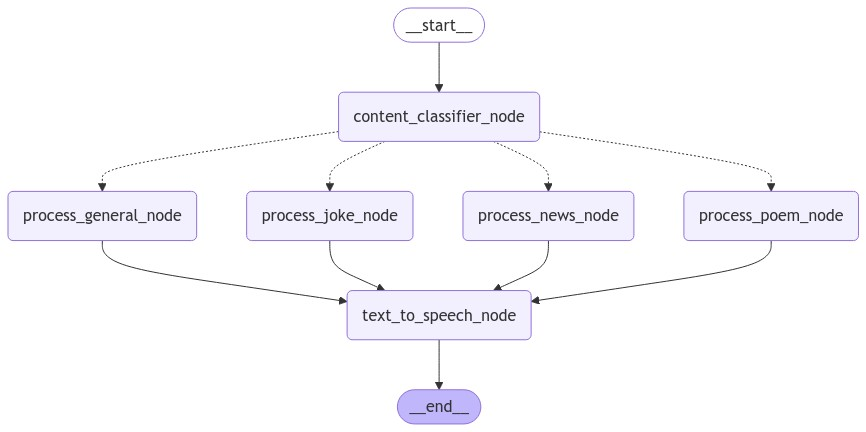

In [33]:
builder: StateGraph = StateGraph(State)

builder.add_node("content_classifier_node", content_classifier_node)
builder.add_node("process_general_node", process_general_node)
builder.add_node("process_poem_node", process_poem_node)
builder.add_node("process_news_node", process_news_node)
builder.add_node("process_joke_node", process_joke_node)
builder.add_node("text_to_speech_node", text_to_speech_node)

builder.add_edge(START, "content_classifier_node")
builder.add_conditional_edges("content_classifier_node", node_decider,{
    "process_general_node": "process_general_node",
    "process_poem_node": "process_poem_node",
    "process_news_node": "process_news_node",
    "process_joke_node": "process_joke_node"
})
builder.add_edge("process_general_node", "text_to_speech_node")
builder.add_edge("process_poem_node", "text_to_speech_node")
builder.add_edge("process_news_node", "text_to_speech_node")
builder.add_edge("process_joke_node", "text_to_speech_node")
builder.add_edge("text_to_speech_node", END)

agent: CompiledStateGraph = builder.compile()

display(Image(agent.get_graph().draw_mermaid_png()))

In [34]:
input_text = "Roses are red, violets are blue, AI is amazing, and so are you!"
result = agent.invoke({"text": input_text,
                       "classification": "",
                       "generation": "",
                      "audio_path": "",
                      })
print(f"Category: {result['classification']}")
print(f"Generation: {result['generation']}")

Category: Poem 

Generation: ##  A Revised Rose

Crimson blooms unfurl, a velvet hue,
While violets whisper, a gentle blue.
AI, a marvel, weaves its magic bright,
And in your presence, all the world takes flight. 



In [35]:
result["audio_path"]

'response.mp3'

In [37]:
input_text = "Breaking news: Scientists discover a new species of deep-sea creature in the Mariana Trench."
result = agent.invoke({"text": input_text,
                       "classification": "",
                       "generation": "",
                      "audio_path": "",
                      })
print(f"Category: {result['classification']}")
print(f"Generation: {result['generation']}")

Category: News 

Generation: ##  Breaking News:  Deep-Sea Discovery in the Mariana Trench

**Good evening, and welcome back. We have breaking news coming in from the world of marine biology. Scientists have just announced the discovery of a new species of deep-sea creature in the Mariana Trench.**

This remarkable find is a testament to the incredible biodiversity still waiting to be discovered in the deepest parts of our oceans. The creature, whose name is yet to be formally announced, was discovered during a recent expedition to the trench, the deepest known point on Earth. 

**We'll be bringing you more information as it becomes available, including details about the creature's appearance, behavior, and potential implications for our understanding of deep-sea ecosystems.** 

**Stay tuned for updates.** 



In [39]:
input_text = "Why don't scientists trust atoms? Because they make up everything!"
result = agent.invoke({"text": input_text,
                       "classification": "",
                       "generation": "",
                      "audio_path": "",
                      })
print(f"Category: {result['classification']}")
print(f"Generation: {result['generation']}")

Category: Joke 

Generation: Here are a few ways to refine the joke "Why don't scientists trust atoms? Because they make up everything!" for humor:

**Playing with the wording:**

* **"Why don't scientists trust atoms? Because they're always making things up!"**  This emphasizes the "make up" part in a way that makes it sound like atoms are lying. 
* **"Why don't scientists trust atoms? Because they're always splitting hairs!"** This uses the scientific concept of nuclear fission to create a pun about being picky or nitpicky.

**Adding a visual element:**

* **"Why don't scientists trust atoms? Because they're always making things up... literally!"**  This could be followed by a picture of an atom with a mischievous grin or a scientist looking suspicious.

**Making it more relatable:**

* **"Why don't scientists trust atoms? Because they're always making up excuses for why they can't be in a relationship!"** This makes the joke more relevant to everyday life.

**Adding a twist:**

* **